# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Conteúdo</p></div>     
   
- Libraries
- Configurations
- Loading Data
- **Data Preparation** 
    - Encoding
    - Normalization
    - Standardzation
    - Feature Selection
- **Model** 
    - Train-Test Split
    - Cross Validation
    - Models
        - LightGBM Classifier
        - XGboost Classifier
        - Artifical Neural Network
- **Hypertuning**
    - Optuna
        - LightGBM Classifier
        - XGboost Classifier
        - Artifical Neural Network
     - Save Best Models
- **Feture Importance**
    - Enssemble Method
        - LightGBM Classifier Feature Importance
        - XGboost Classifier Feature Importance
    - Filter Method
        - Anova
        - Pearson Correlation
    - Wrapper Methods
        - Shapley

## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Libraries</p></div>

In [1]:
# !pip install -U scikit-learn
# !pip install lightgbm
# !pip install optuna
# !pip install category-encoders
# !pip install -q -U torch watermark
# !pip install -q -U scikit-learn watermark
# !pip install graphviz
# !pip install shap

In [2]:
# Basic Tools
import pandas as pd
import numpy as np
from datetime import datetime as dt

# Visualization Tools
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# File / OS tools
import json
from watermark import watermark
import os
import dotenv


# Machine Learning Models
import xgboost
from xgboost import XGBClassifier, plot_importance
import lightgbm
from lightgbm import LGBMClassifier, plot_importance 

# Deep Learning Models
import torch
from torch import nn, optim
import torch.nn.functional as F

# Preprocessing Tools
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder
from category_encoders.count import CountEncoder

# Model Selection Tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
import optuna

# Model Evaluation Tools
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, classification_report

# Feature Importance Tools
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel, VarianceThreshold, SelectPercentile
import shap
from shap import plots

## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Configurations</p></div>

In [3]:
#Global Seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,scikit-learn,optuna,lightgbm,torch,shap,category_encoders
#watermark --iversion

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

numpy            : 1.23.4
pandas           : 1.5.1
scikit-learn     : 0.0.post1
optuna           : 3.1.1
lightgbm         : 3.3.5
torch            : 2.0.0
shap             : 0.41.0
category_encoders: 2.6.0



# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Data Preparation</p></div> 

In [5]:
dotenv.load_dotenv(dotenv.find_dotenv())
ROOT_DIR = os.getenv('ROOT_DIR')
data = pd.read_csv(f'{ROOT_DIR}/data/data_processed/hotel_bookings_processed.csv')

In [29]:
data_prep = data.copy()
data_prep.tail(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,people,kids,days_stay,country_name,continentes
119231,City Hotel,0,34,2017,8,35,31,2,5,2,...,157.71,0,4,Check-Out,2017-09-07,2,0,7,Germany,Europe
119232,City Hotel,0,109,2017,8,35,31,2,5,2,...,104.40,0,0,Check-Out,2017-09-07,2,0,7,United Kingdom,Europe
119233,City Hotel,0,205,2017,8,35,29,2,7,2,...,151.20,0,2,Check-Out,2017-09-07,2,0,9,Germany,Europe


In [30]:
data_prep.isna().sum().sum()

0

In [31]:
data.booking_changes.value_counts()

0     101254
1      12669
2       3779
3        914
4        367
5        115
6         61
7         29
8         14
9          8
10         6
13         5
14         3
15         3
17         2
16         2
12         1
18         1
11         1
Name: booking_changes, dtype: int64

In [32]:
data_prep

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,people,kids,days_stay,country_name,continentes
0,Resort Hotel,0,342,2015,7,27,1,0,0,2,...,0.00,0,0,Check-Out,2015-07-01,2,0,0,Portugal,Native
1,Resort Hotel,0,737,2015,7,27,1,0,0,2,...,0.00,0,0,Check-Out,2015-07-01,2,0,0,Portugal,Native
2,Resort Hotel,0,7,2015,7,27,1,0,1,1,...,75.00,0,0,Check-Out,2015-07-02,1,0,1,United Kingdom,Europe
3,Resort Hotel,0,13,2015,7,27,1,0,1,1,...,75.00,0,0,Check-Out,2015-07-02,1,0,1,United Kingdom,Europe
4,Resort Hotel,0,14,2015,7,27,1,0,2,2,...,98.00,0,1,Check-Out,2015-07-03,2,0,2,United Kingdom,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119229,City Hotel,0,23,2017,8,35,30,2,5,2,...,96.14,0,0,Check-Out,2017-09-06,2,0,7,Belgium,Europe
119230,City Hotel,0,102,2017,8,35,31,2,5,3,...,225.43,0,2,Check-Out,2017-09-07,3,0,7,France,Europe
119231,City Hotel,0,34,2017,8,35,31,2,5,2,...,157.71,0,4,Check-Out,2017-09-07,2,0,7,Germany,Europe
119232,City Hotel,0,109,2017,8,35,31,2,5,2,...,104.40,0,0,Check-Out,2017-09-07,2,0,7,United Kingdom,Europe


In [33]:
data_prep['booking_changes'].unique()

array([ 3,  4,  0,  1,  2,  5, 17,  6,  8,  7, 10, 16,  9, 13, 12, 14, 15,
       18, 11])

### <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Encoding</p></div>

In [34]:
## CATEGORICAL FEATURES

hotel_dict = {'City Hotel': 0,  'Resort Hotel':1}
data_prep['hotel'] = data_prep['hotel'].map(hotel_dict) 

meal_dict = {'SC': 0,  'HB': 1, 'BB': 2, 'FB':3}
data_prep['meal'] = data_prep['meal'].map(meal_dict)

continentes_dict = {'Unknow':-1,'Native': 0,'Europe': 1, 'Asia': 2, 'North America':3, 'South America':4, 'Oceania':5, 'Africa':6 }
data_prep['continentes'] = data_prep['continentes'].map(continentes_dict) 

market_segment_dict = {'Undefined':-1,'Online TA': 0,'Offline TA/TO': 1, 'Groups': 2, 'Corporate':3, 'Direct':4, 'Aviation':5, 'Complementary':6}
data_prep['market_segment'] = data_prep['market_segment'].map(market_segment_dict)

distribution_dict = {'Undefined':-1,'TA/TO': 0,'Direct': 1, 'Corporate': 2, 'GDS':3}
data_prep['distribution_channel'] = data_prep['distribution_channel'].map(distribution_dict) 

customer_type_dict = {'Transient': 0,'Transient-Party': 1, 'Contract': 2, 'Contract':3, 'Group':4}
data_prep['customer_type'] = data_prep['customer_type'].map(customer_type_dict) 


## NUMERICAL FEATURES
data_prep['previous_cancellations'] = data_prep['previous_cancellations'].apply(lambda x: 2 if (x >= 2) else x)
data_prep['previous_bookings_not_canceled'] = data_prep['previous_bookings_not_canceled'].apply(lambda x: 2 if (x >= 2) else x)
data_prep['booking_changes'] = data_prep['booking_changes'].apply(lambda x: 2 if (x >= 2) else x)

n = 20
top_agents = data_prep['agent'].value_counts().nlargest(n).index
top_companies = data_prep['company'].value_counts().nlargest(n).index
data_prep['agent'] = np.where(data_prep['agent'].isin(top_agents), data_prep['agent'], -1)
data_prep['company'] = np.where(data_prep['company'].isin(top_companies), data_prep['company'], -1)

In [111]:
data.market_segment.unique()

array(['Direct', 'Corporate', 'Online TA', 'Offline TA/TO',
       'Complementary', 'Groups', 'Undefined', 'Aviation'], dtype=object)

## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Feature Selection</p></div>

There are some features that we will **not use under any circumstances** in our machine learning model:

**reservation_status:** Data leakage<br>
**reservation_status_date:** Data Leakage<br>
**deposit_type:** The dataset seems to contain several wrong values about the type of deposit and its relationship with cancellations<br>


The remaining features were selected based on various tests that are not described on the notebook, with a focus on performance and simplicity:

**adults, children, babies:** Replaced by "people"<br>
**stays_in_weekend_nights,stays_in_week_nights:** Replaced with days_stay<br>
**country:** Replaced by continentes 


In [35]:
selected_features = ['hotel',
                     #'is_canceled',
                     'lead_time',
                     'arrival_date_year',   
                     #'arrival_date_month',
                     'arrival_date_week_number',
                     #'arrival_date_day_of_month',
                     #'stays_in_weekend_nights',                    
                     #'stays_in_week_nights',
                     #'adults',
                     #'children',
                     #'babies',
                     'meal',
                     #'country',
                     'market_segment',
                     'distribution_channel',
                     'is_repeated_guest',
                     'previous_cancellations',
                     #'assigned_room_type',
                     'previous_bookings_not_canceled',
                     #'reserved_room_type',
                     'booking_changes',
                     #'deposit_type',
                     'agent',
                     'company',
                     #'days_in_waiting_list',
                     'customer_type',
                     'adr',
                     'required_car_parking_spaces',
                     'total_of_special_requests',
                     #'reservation_status_date',
                     'people',
                     'continentes',
                     #'kids',
                     'days_stay',
                     #'foreigner'
                     #'arrival_date'
                    ]

In [36]:
target = 'is_canceled'

In [37]:
data_prep[selected_features]

,hotel,lead_time,arrival_date_year,arrival_date_week_number,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,customer_type,adr,required_car_parking_spaces,total_of_special_requests,people,continentes,days_stay
0,1,342,2015,27,2,4,1,0,0,0,2,0,0,0,0.00,0,0,2,0,0
1,1,737,2015,27,2,4,1,0,0,0,2,0,0,0,0.00,0,0,2,0,0
2,1,7,2015,27,2,4,1,0,0,0,0,0,0,0,75.00,0,0,1,1,1
3,1,13,2015,27,2,3,2,0,0,0,0,-1,0,0,75.00,0,0,1,1,1
4,1,14,2015,27,2,0,0,0,0,0,0,240,0,0,98.00,0,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119229,0,23,2017,35,2,1,0,0,0,0,0,-1,0,0,96.14,0,0,2,1,7
119230,0,102,2017,35,2,0,0,0,0,0,0,9,0,0,225.43,0,2,3,1,7
119231,0,34,2017,35,2,0,0,0,0,0,0,9,0,0,157.71,0,4,2,1,7
119232,0,109,2017,35,2,0,0,0,0,0,0,-1,0,0,104.40,0,0,2,1,7


## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Normalization</p></div>

In [52]:
#numerical_features = data[selected_features].select_dtypes(include = ['number'])#.columns.values

In [53]:
#sns.pairplot(numerical_features, aspect=1.5);

In [54]:
log_columns = data_prep[selected_features].skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns > 0.75]
print('Columns/Skew\n',log_columns)    

Columns/Skew
 adr                               10.600349
people                            10.312170
company                            7.963720
previous_bookings_not_canceled     6.184619
is_repeated_guest                  5.364531
previous_cancellations             4.468142
required_car_parking_spaces        4.162833
days_stay                          3.190190
customer_type                      2.731746
booking_changes                    2.543387
continentes                        2.389070
distribution_channel               2.284368
agent                              1.688023
total_of_special_requests          1.349284
lead_time                          1.345750
market_segment                     1.115390
dtype: float64


In [55]:
# for col in log_columns.index:
#     data_prep[col] = np.log1p(data_prep[col])

In [56]:
rbs = RobustScaler()
for col in data_prep[selected_features]:
    data_prep[col] = rbs.fit_transform(data_prep[[col]]).squeeze()  

In [57]:
data_prep[selected_features]

,hotel,lead_time,arrival_date_year,arrival_date_week_number,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,customer_type,adr,required_car_parking_spaces,total_of_special_requests,people,continentes,days_stay
0,1.0,1.909091,-1.0,-0.045455,0.0,1.5,1.0,0.0,0.0,0.0,2.0,-0.642857,0.0,0.0,-1.679646,0.0,0.0,0.0,-1.0,-1.5
1,1.0,4.671329,-1.0,-0.045455,0.0,1.5,1.0,0.0,0.0,0.0,2.0,-0.642857,0.0,0.0,-1.679646,0.0,0.0,0.0,-1.0,-1.5
2,1.0,-0.433566,-1.0,-0.045455,0.0,1.5,1.0,0.0,0.0,0.0,0.0,-0.642857,0.0,0.0,-0.352212,0.0,0.0,-1.0,0.0,-1.0
3,1.0,-0.391608,-1.0,-0.045455,0.0,1.0,2.0,0.0,0.0,0.0,0.0,-0.714286,0.0,0.0,-0.352212,0.0,0.0,-1.0,0.0,-1.0
4,1.0,-0.384615,-1.0,-0.045455,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,16.500000,0.0,0.0,0.054867,0.0,1.0,0.0,0.0,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119229,0.0,-0.321678,1.0,0.318182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.714286,0.0,0.0,0.021947,0.0,0.0,0.0,0.0,2.0
119230,0.0,0.230769,1.0,0.318182,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.310265,0.0,2.0,1.0,0.0,2.0
119231,0.0,-0.244755,1.0,0.318182,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.111681,0.0,4.0,0.0,0.0,2.0
119232,0.0,0.279720,1.0,0.318182,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,-0.714286,0.0,0.0,0.168142,0.0,0.0,0.0,0.0,2.0


# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Model</p></div> 

## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Train-Test Split</p></div>

In [58]:
y = data_prep[target]
X = data_prep[selected_features]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((95387, 20), (95387,), (23847, 20), (23847,))

In [59]:
# pipeline.fit(X_train, y_train)

# # Avaliar o modelo
# from sklearn.metrics import accuracy_score
# y_pred = pipeline.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Acurácia do modelo: {accuracy:.3f}')

## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Cross Validation</p></div>

In [60]:
def CM(y, y_pred):
    labels = ["Não Cancelado", "Cancelado"]
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")  
    plt.show()
    print("Score: \n", classification_report(y,y_pred)) 


def ROC(model, y, y_prob, model_dict):
    score_metrics_auc = pd.DataFrame(columns=['Model','AUC'])
    
    #y_prob = model.fit(X,y)
    #y_prob = model.predict_proba(X)
    #y_prob = y_prob[:,1]   
    
    
    fpr,tpr, threshold = roc_curve(y,y_prob)
    auc = roc_auc_score(y,y_prob)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr,tpr, color='steelblue', label = model_dict)    
    plt.title("ROC")
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.plot([0,1],[0,1], color='black', linestyle='--')
    plt.xlabel("False Positives Rate (1- Specifity)")
    plt.ylabel("True Positives Rate (Sensitivity)")
    plt.legend(loc = 'lower right') 
    plt.show()
    print(f"AUC: {auc:.4f}\n\n") 
    
    #score_metrics_auc.loc[i]=[pipe_dict[i], auc]   
   
    return y_prob, auc

In [61]:
def CVS(model, X, y, model_dict=''):    
    
   
    number_folds = 5
    
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED )
    
    y_prob = cross_val_predict(model, X, y, cv=Kfold, method='predict_proba', verbose=False)    
    y_prob = y_prob[:,1]
    
    ### Defining threshold ###
    y_pred = np.empty(shape=(len(y_prob)))
    threshold = 0.5
    for i in range(len(y_prob)):    
        if y_prob[i] >= threshold:
            y_pred[i] = 1  
        else:
            y_pred[i] = 0  
   
    CM(y,y_pred)
    ROC(model, y, y_prob, model_dict) 
  
    scores = cross_validate(model, X, y, cv = Kfold, scoring=['accuracy','precision','recall','f1','roc_auc'], return_train_score=True)
    
    df = pd.DataFrame.from_dict(scores).T
    df['mean_folds5'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    #display(df[['mean_folds5','std']])
    display(df)
    return y_prob, y_pred, scores

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">LightGBM</p></div>

In [62]:
lgbm = LGBMClassifier(random_state=RANDOM_SEED)

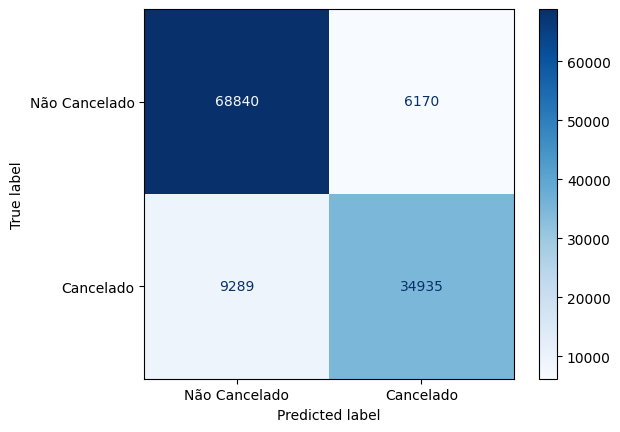

Score: 
               precision    recall  f1-score   support

           0       0.88      0.92      0.90     75010
           1       0.85      0.79      0.82     44224

    accuracy                           0.87    119234
   macro avg       0.87      0.85      0.86    119234
weighted avg       0.87      0.87      0.87    119234



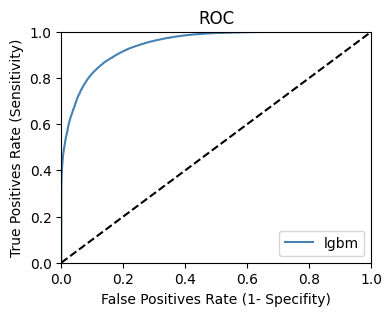

AUC: 0.9451




,0,1,2,3,4,mean_folds5,std
fit_time,0.197690,0.217087,0.198151,0.171618,0.186900,0.194289,0.014932
score_time,0.040035,0.058229,0.040489,0.038690,0.041038,0.043696,0.007308
test_accuracy,0.870340,0.867824,0.871766,0.871137,0.870670,0.870347,0.001350
train_accuracy,0.874375,0.874731,0.873368,0.873589,0.874879,0.874189,0.000606
test_precision,0.851007,0.847007,0.853426,0.849479,0.848584,0.849901,0.002188
train_precision,0.858175,0.856751,0.854233,0.854304,0.855518,0.855796,0.001505
test_recall,0.788468,0.785529,0.789938,0.793103,0.792741,0.789956,0.002810
train_recall,0.792221,0.795218,0.794087,0.794709,0.797315,0.794710,0.001651
test_f1,0.818545,0.815110,0.820456,0.820324,0.819712,0.818829,0.001978
train_f1,0.823880,0.824838,0.823062,0.823429,0.825392,0.824120,0.000870


In [63]:
lgbm_y_prob, lgbm_y_pred, lgbm_scores  = CVS(lgbm,X,y,'lgbm')

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">XGboost</p></div>

In [64]:
xgb = XGBClassifier(random_state=RANDOM_SEED)

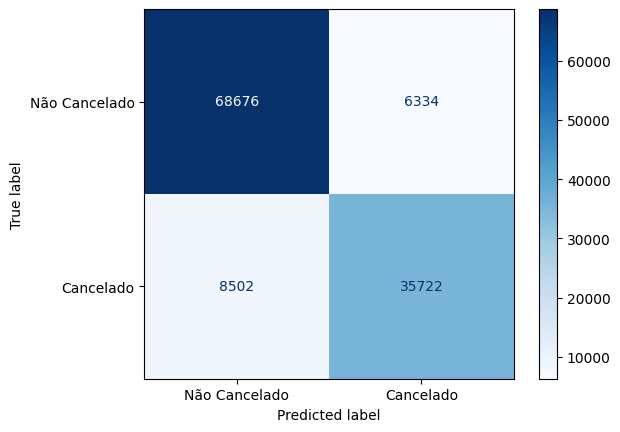

Score: 
               precision    recall  f1-score   support

           0       0.89      0.92      0.90     75010
           1       0.85      0.81      0.83     44224

    accuracy                           0.88    119234
   macro avg       0.87      0.86      0.87    119234
weighted avg       0.87      0.88      0.87    119234



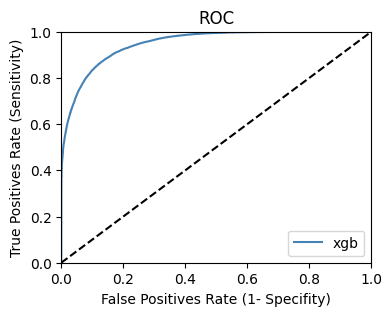

AUC: 0.9493




,0,1,2,3,4,mean_folds5,std
fit_time,1.397228,1.329855,1.389935,1.386891,1.430571,1.386896,0.032488
score_time,0.031188,0.031201,0.032730,0.030951,0.033774,0.031969,0.001102
test_accuracy,0.876337,0.873066,0.876546,0.876840,0.875073,0.875572,0.001391
train_accuracy,0.891348,0.890499,0.889849,0.890729,0.888571,0.890199,0.000945
test_precision,0.849289,0.844260,0.853396,0.851416,0.848651,0.849402,0.003067
train_precision,0.871021,0.870512,0.867060,0.868931,0.866671,0.868839,0.001757
test_recall,0.810401,0.806557,0.805540,0.809158,0.807101,0.807751,0.001774
train_recall,0.829956,0.827921,0.830323,0.830691,0.826767,0.829131,0.001522
test_f1,0.829390,0.824978,0.828777,0.829749,0.827354,0.828050,0.001740
train_f1,0.849993,0.848682,0.848294,0.849381,0.846248,0.848520,0.001277


In [65]:
xgb_y_prob, xgb_y_pred, xgb_scores  = CVS(xgb,X,y,'xgb')

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">ANN</p></div>

In [66]:
X_train_nn = torch.from_numpy(X_train.to_numpy()).float()
y_train_nn = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_val_nn = torch.from_numpy(X_val.to_numpy()).float()
y_val_nn = torch.squeeze(torch.from_numpy(y_val.to_numpy()).float())

In [67]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device
#device(type='cuda')

device(type='cpu')

In [68]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(95387, 20) (95387,)
(23847, 20) (23847,)


In [69]:
#batch_size = 64
#num_classes = 1

input_size = X.shape[1]
num_classes = 1
learning_rate = 0.01
hidden_size_1 = 200
hidden_size_2 = 400
dropout_rate = 0.1

In [70]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, dropout_rate):
        super(Net, self).__init__()
        self.hiden_layer1 = nn.Linear(input_size, hidden_size_1)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.hiden_layer2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.output = nn.Linear(hidden_size_2, 1)
        
    def forward(self, x):
        x = torch.relu(self.hiden_layer1(x))
        x = self.dropout1(x)
        x = torch.relu(self.hiden_layer2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.output(x))
        return x

In [71]:
net = Net(input_size=input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, dropout_rate=dropout_rate)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train_nn, y_train_nn = X_train_nn.to(device), y_train_nn.to(device)
X_val_nn, y_val_nn = X_val_nn.to(device), y_val_nn.to(device)

net = net.to(device)
criterion = criterion.to(device)

In [73]:
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(.5).view(-1)
    acc =  (y_true == predicted).sum().float() / len(y_true)
    
def calculate_f1(y_true, y_pred):
    #Class Probability
    predicted = y_pred.ge(.5).squeeze().long()
    y_true = y_true.long()
    #F1 Score Calculator
    f1 = f1_score(y_true, predicted, average='micro')

    return f1

def calculate_precision(y_true, y_pred):
    #Class Probability
    predicted = y_pred.ge(.5).squeeze().long()
    y_true = y_true.long()
    #F1 Score Calculator
    precision = precision_score(y_true, predicted)

    return precision 

def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

In [74]:
# Sub-Paramters
early_stop_epochs = 5
patience = 0
best_val_loss = float('inf')
num_epoch = 500

for epoch in range(num_epoch):
    y_pred = net(X_train_nn)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train_nn)
    if epoch % 10 == 0:
        train_score = calculate_precision(y_train_nn, y_pred)
        y_val_pred = net(X_val_nn)
        y_val_pred = torch.squeeze(y_val_pred)
        val_loss = criterion(y_val_pred, y_val_nn)
        val_score = calculate_precision(y_val_nn, y_val_pred)
        print(f'epoch {epoch} - train loss: {round_tensor(train_loss)}, train precision : {round_tensor(train_score)} val loss: {round_tensor(val_loss)}, val precision: {round_tensor(val_score)}')
        # Verify boost on validation set
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1
            if patience >= early_stop_epochs:
                print('Early Stopping')
                break
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

epoch 0 - train loss: 0.685, train precision : 0.5 val loss: 0.685, val precision: 0.501



KeyboardInterrupt



# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Hypertuning</p></div> 

### <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Optuna</p></div>

In [75]:
weight = round(float((y.value_counts()[0])/(y.value_counts()[1])),3) #sum_neg/sum_p
weight

1.696

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">LightGBM</p></div>

In [79]:
def objective(trial):
    param_grid = {
        'objective': trial.suggest_categorical('objective', ['binary']),#binary         
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','dart']), 
        'metric': trial.suggest_categorical('metric', ['auc']), 
        #'eval_metric': trial.suggest_categorical('eval_metric', ['f1']),   
        #"metric": "binary_error",
        "num_leaves": trial.suggest_int("num_leaves", 100, 300, step=20),
        "max_depth": trial.suggest_int("max_depth", 6, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        #'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 0.9),
        #'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 0.9),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        #'is_unbalance': trial.suggest_categorical('is_unbalance', [False,True]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
        #'boost_from_average': trial.suggest_categorical('boost_from_average', [False,True]),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1,weight]),
        #'early_stopping_rounds':10,
        #'verbosity':0,
        'seed': RANDOM_SEED
    }
    
    model = LGBMClassifier(**param_grid)
    
    number_folds = 3
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED )
    #scores = cross_val_score(model, X, y, cv=Kfold, scoring="precision")
    #return scores.mean()
    y_pred = cross_val_predict(model, X, y, cv=Kfold)
    return f1_score(y,y_pred)
    

In [80]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING) 
#optuna.logging.set_verbosity(optuna.logging.DEBUG) 
study.optimize(objective, n_trials=100);

trial = study.best_trial

In [81]:
# Print the result
lgbm_best_params = study.best_params
lgbm_best_score = study.best_value
print(f"Best score: {lgbm_best_score}\n")
print(f"Optimized parameters: {lgbm_best_params}\n")

Best score: 0.83979712631819

Optimized parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_leaves': 280, 'max_depth': 11, 'learning_rate': 0.09754636779761254, 'reg_alpha': 1.2209481616780184e-07, 'reg_lambda': 4.598794059291876e-06, 'subsample_freq': 5, 'min_child_samples': 2, 'scale_pos_weight': 1.696}



In [83]:
lgbm_best_params

{'objective': 'binary',
 'boosting_type': 'gbdt',
 'metric': 'auc',
 'num_leaves': 280,
 'max_depth': 11,
 'learning_rate': 0.09754636779761254,
 'reg_alpha': 1.2209481616780184e-07,
 'reg_lambda': 4.598794059291876e-06,
 'subsample_freq': 5,
 'min_child_samples': 2,
 'scale_pos_weight': 1.696}

In [25]:
# lgbm_best_params = {'objective': 'binary',
#  'boosting_type': 'gbdt',
#  'metric': 'binary_logloss',
#  'num_leaves': 280,
#  'max_depth': 12,
#  'learning_rate': 0.0816305181323602,
#  'lambda_l1': 0.01827136049971484,
#  'lambda_l2': 0.0431613380574575,
#  'bagging_freq': 3,
#  'min_child_samples': 6,
#  'boost_from_average': True,
#  'scale_pos_weight': 1}

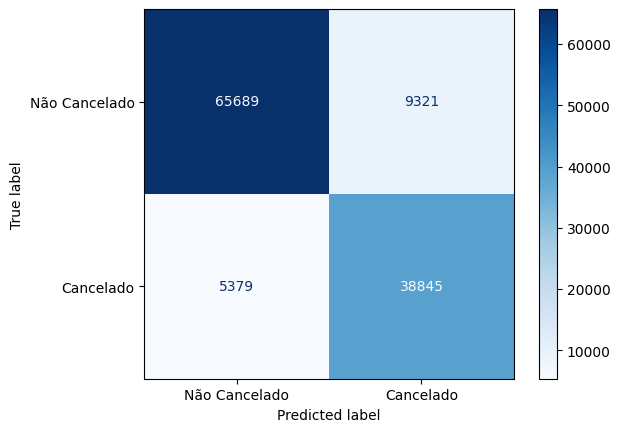

Score: 
               precision    recall  f1-score   support

           0       0.92      0.88      0.90     75010
           1       0.81      0.88      0.84     44224

    accuracy                           0.88    119234
   macro avg       0.87      0.88      0.87    119234
weighted avg       0.88      0.88      0.88    119234



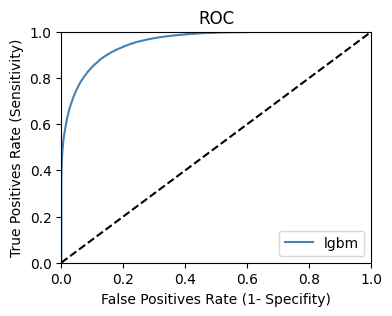

AUC: 0.9546




,0,1,2,3,4,mean_folds5,std
fit_time,0.560173,0.668935,0.638900,0.598206,0.645926,0.622428,0.038598
score_time,0.060358,0.075712,0.055373,0.062819,0.060605,0.062974,0.006819
test_accuracy,0.877301,0.874282,0.879230,0.877846,0.874906,0.876713,0.001852
train_accuracy,0.907199,0.907042,0.907482,0.909568,0.907536,0.907765,0.000920
test_precision,0.806081,0.801485,0.811358,0.807868,0.805674,0.806493,0.003209
train_precision,0.842558,0.842692,0.843039,0.847451,0.842851,0.843718,0.001873
test_recall,0.881176,0.878689,0.878689,0.879932,0.873360,0.878369,0.002669
train_recall,0.922101,0.921366,0.922270,0.922185,0.922753,0.922135,0.000446
test_f1,0.841957,0.838313,0.843682,0.842362,0.838153,0.840893,0.002246
train_f1,0.880537,0.880274,0.880877,0.883240,0.880994,0.881184,0.001059


In [82]:
model_lgbm_tuned = LGBMClassifier(**lgbm_best_params)
y_prob_lgbm_tuned, y_pred_lgbm_tuned, scores_lgbm_tuned  = CVS(model_lgbm_tuned,X,y,'lgbm')

In [88]:
lgbm_best_params = {'objective': 'binary',
 'boosting_type': 'gbdt',
 'metric': 'auc',
 #'num_leaves': 280,
 'max_depth': 11,
 'learning_rate': 0.1,
 'reg_alpha': 1.2e-07,
 'reg_lambda': 4.6e-06,
 'subsample_freq': 5,
 'min_child_samples': 2,
 'scale_pos_weight': 1.696}


param_range = np.arange(10, 300, 10)


train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**lgbm_best_params,
        num_leaves = i
)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))

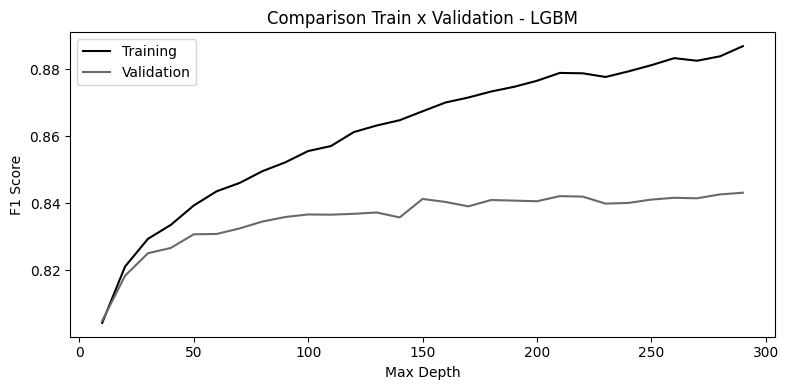

In [87]:
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, test_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("Num Leaves")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

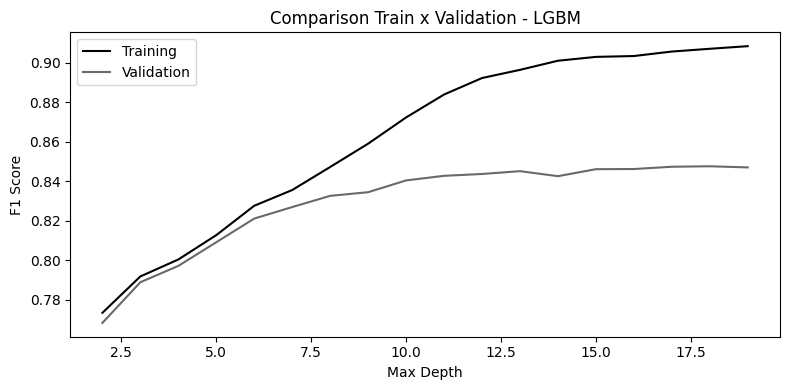

In [92]:
lgbm_best_params = {'objective': 'binary',
 'boosting_type': 'gbdt',
 'metric': 'auc',
 'num_leaves': 280,
 #'max_depth': 11,
 'learning_rate': 0.1,
 'reg_alpha': 1.2e-07,
 'reg_lambda': 4.6e-06,
 'subsample_freq': 5,
 'min_child_samples': 2,
 'scale_pos_weight': 1.696}


param_range = np.arange(2, 20, 1)


train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**lgbm_best_params,
        max_depth = i
)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))
    
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("Max Depth")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

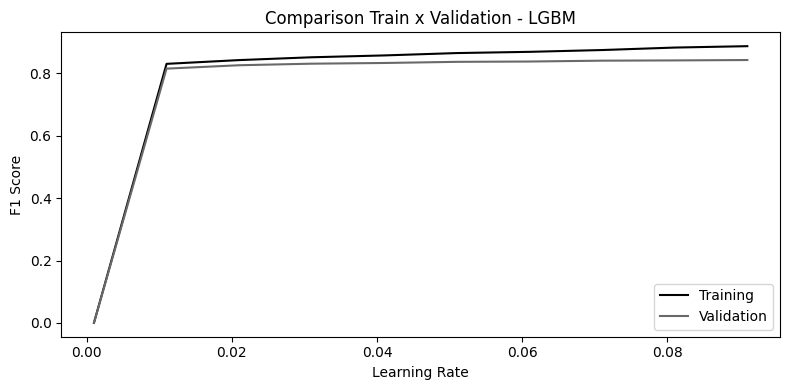

In [96]:
lgbm_best_params = {'objective': 'binary',
 'boosting_type': 'gbdt',
 'metric': 'auc',
 'num_leaves': 280,
 'max_depth': 12,
 #'learning_rate': 0.1,
 'reg_alpha': 1.2e-07,
 'reg_lambda': 4.6e-06,
 'subsample_freq': 5,
 'min_child_samples': 2,
 'scale_pos_weight': 1.696}


param_range = np.arange(0.001, 0.1, 0.01)


train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**lgbm_best_params,
        learning_rate = i
)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))
    
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("Learning Rate")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

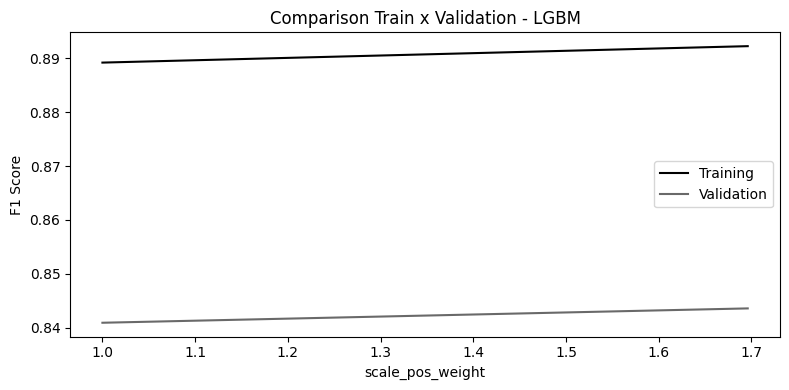

In [99]:
lgbm_best_params = {'objective': 'binary',
 'boosting_type': 'gbdt',
 'metric': 'auc',
 'num_leaves': 280,
 'max_depth': 12,
 'learning_rate': 0.1,
 'reg_alpha': 1.2e-07,
 'reg_lambda': 4.6e-06,
 'subsample_freq': 5,
 'min_child_samples': 2,
 #'scale_pos_weight': 1.696
                   }


param_range = [1,1.696]


train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**lgbm_best_params,
        scale_pos_weight = i
)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))
    
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("scale_pos_weight")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">XGBoost</p></div>

In [108]:
def objective(trial): 
    
    param_grid = {
        'objective': trial.suggest_categorical('objective', ['binary:logistic']),  
        'booster': trial.suggest_categorical('booster', ['gbtree','dart']),
        'eval_metric': trial.suggest_categorical('eval_metric', ['auc']),    
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 150, step=50),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.4, 0.9),     
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1,weight]),
        'seed': trial.suggest_categorical('seed', [RANDOM_SEED]),
        #'early_stopping_rounds':100,        
    }

    model = XGBClassifier(**param_grid)
    number_folds = 3
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED )
    y_pred = cross_val_predict(model, X, y, cv=Kfold)
    
    return f1_score(y,y_pred)

In [109]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING) 
study.optimize(objective, n_trials=30); 

trial = study.best_trial

In [107]:
# Print the result
xgb_best_params = study.best_params
xgb_best_score = study.best_value
print(f"Best score: {xgb_best_score}\n")
print(f"Optimized parameters: {xgb_best_params}\n")

ValueError: No trials are completed yet.

In [46]:
xgb_best_params

{'objective': 'binary:logistic',
 'booster': 'dart',
 'eval_metric': 'auc',
 'max_depth': 7,
 'learning_rate': 0.002774911132411461,
 'n_estimators': 150,
 'alpha': 1.0935276616172592e-07,
 'lambda': 3.3902571188489596e-06,
 'min_child_weight': 2,
 'colsample_bytree': 0.43678905247358146,
 'scale_pos_weight': 1,
 'seed': 42}

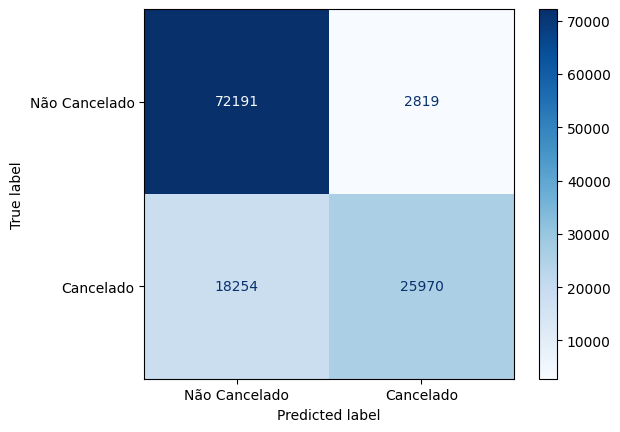

Score: 
               precision    recall  f1-score   support

           0       0.80      0.96      0.87     75010
           1       0.90      0.59      0.71     44224

    accuracy                           0.82    119234
   macro avg       0.85      0.77      0.79    119234
weighted avg       0.84      0.82      0.81    119234



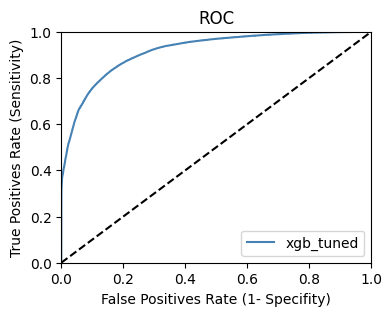

AUC: 0.9172




,0,1,2,3,4,mean_folds5,std
fit_time,10.070358,9.209162,9.402373,9.101540,9.815909,9.519868,0.367701
score_time,0.282207,0.296957,0.331874,0.256789,0.277208,0.289007,0.024997
test_accuracy,0.824590,0.821319,0.825848,0.824213,0.820347,0.823263,0.002080
train_accuracy,0.824976,0.823980,0.823446,0.824934,0.824915,0.824450,0.000626
test_precision,0.900929,0.904518,0.907858,0.901605,0.895559,0.902094,0.004084
train_precision,0.901910,0.903951,0.902650,0.902482,0.903940,0.902987,0.000820
test_recall,0.592199,0.579423,0.590390,0.590503,0.583673,0.587238,0.004878
train_recall,0.592555,0.587891,0.587326,0.591961,0.590729,0.590092,0.002120
test_f1,0.714646,0.706361,0.715489,0.713622,0.706736,0.711371,0.003984
train_f1,0.715214,0.712441,0.711622,0.714961,0.714518,0.713751,0.001445


In [47]:
model_xgb_tuned = XGBClassifier(**xgb_best_params)
y_prob_xgb_tuned, y_pred_xgb_tuned, scores_xgb_tuned  = CVS(model_xgb_tuned,X,y,'xgb_tuned')  

In [48]:
#optuna.visualization.plot_optimization_history(study)

In [49]:
#optuna.visualization.plot_slice(study)

In [50]:
#optuna.visualization.plot_param_importances(study)

In [51]:
xgb_best_params

{'objective': 'binary:logistic',
 'booster': 'dart',
 'eval_metric': 'auc',
 'max_depth': 7,
 'learning_rate': 0.002774911132411461,
 'n_estimators': 150,
 'alpha': 1.0935276616172592e-07,
 'lambda': 3.3902571188489596e-06,
 'min_child_weight': 2,
 'colsample_bytree': 0.43678905247358146,
 'scale_pos_weight': 1,
 'seed': 42}

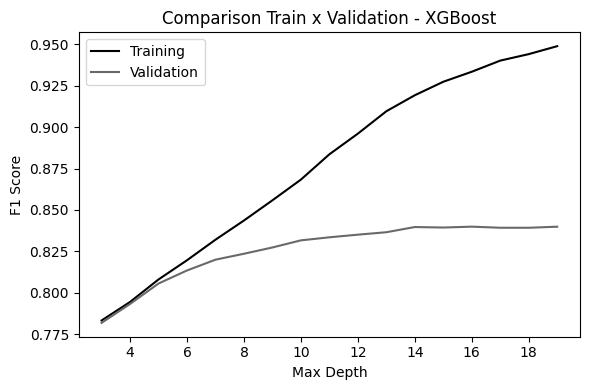

In [129]:
xgb_best_params = {'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'booster': 'gbtree',
 #'max_depth': 10,
 'learning_rate': 0.09971203875947736,
 'n_estimators': 150,
 'alpha': 2.957003467711026e-08,
 'lambda': 4.009830502312534e-07,
 'min_child_weight': 5,
 'colsample_bytree': 0.4584833524080041,
 'scale_pos_weight': 1.696,
 'seed': 42}


param_range = np.arange(3, 20, 1)


train_scores = [ ]
test_scores = [ ]
for i in param_range:
    xgb = XGBClassifier(**xgb_best_params,
        max_depth = i
)
    xgb.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,xgb.predict(X_train)))
    test_scores.append(f1_score(y_val,xgb.predict(X_val)))
    

plt.subplots(1, figsize=(6,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, test_scores, label="Validation", color="dimgrey")

 
plt.title("Comparison Train x Validation - XGBoost")
plt.xlabel("Max Depth")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()    

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">ANN</p></div>

In [ ]:
def objective_ann(trial):
    input_size = X.shape[1]
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    hidden_size_1 = trial.suggest_int('hidden_size_1', 100, 400, step=50)
    hidden_size_2 = trial.suggest_int('hidden_size_2', 100, 400, step=50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4, step=0.1)

    net = Net(input_size=input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, dropout_rate=dropout_rate)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    early_stop_epochs = 30
    patience = 0
    best_val_loss = float('inf')
    num_epoch = 300

    for epoch in range(num_epoch):
        y_pred = net(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)
        if epoch % 10 == 0:
            train_score = calculate_f1(y_train, y_pred)
            y_val_pred = net(X_val)
            y_val_pred = torch.squeeze(y_val_pred)
            val_loss = criterion(y_val_pred, y_val)
            val_acc = calculate_f1(y_val, y_val_pred)
            # Verificar se houve melhora no conjunto de validação
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience = 0
            else:
                patience += 1
                if patience >= early_stop_epochs:
                    break
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    return val_acc

study = optuna.create_study(direction='maximize')
study.optimize(objective_ann, n_trials=100)

trial = study.best_trial

In [ ]:
# Print the result
nn_best_params = study.best_params
nn_best_score = study.best_value
print(f"Best score: {nn_best_score}\n")
print(f"Optimized parameters: {nn_best_params}\n")

In [108]:
data_prep

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,adults,meal,is_repeated_guest,previous_cancellations,adr,required_car_parking_spaces,total_of_special_requests,kids,days_stay,agent_encoded,company_encoded,market_segment_Aviation,...,agent_14,agent_28,agent_240,agent_241,agent_250,company_-1,company_0,company_40,company_45,company_67,company_153,company_154,company_174,company_219,company_223,company_281,company_405
0,1,0,342,2015,27,2,2,0,0,0.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,737,2015,27,2,2,0,0,0.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0,7,2015,27,1,2,0,0,75.0000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0,13,2015,27,1,2,0,0,75.0000,0,0,0,1,-1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,0,14,2015,27,2,2,0,0,98.0000,0,1,0,2,240,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119229,0,0,23,2017,35,2,2,0,0,96.1400,0,0,0,7,-1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
119230,0,0,102,2017,35,3,2,0,0,225.4300,0,2,0,7,9,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
119231,0,0,34,2017,35,2,2,0,0,157.7100,0,4,0,7,9,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
119232,0,0,109,2017,35,2,2,0,0,104.4000,0,0,0,7,-1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Save Model</p></div> 

In [132]:
params_dir = os.path.join(ROOT_DIR, "config", "params")
os.makedirs(params_dir, exist_ok=True) #O parâmetro exist_ok=True faz com que a função não retorne um erro caso a pasta já exista.
now = dt.now().strftime('%Y%m%d%H%M%S')

    
# for dirname, _, filenames in os.walk(f'{ROOT_DIR}\config\params'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))    

In [ ]:
filename_xgb = f'xgb_best_params_{now}_v1.0.json'
params_path = os.path.join(params_dir, filename_xgb)


with open(params_path, 'w') as f:
    json.dump(xgb_best_params, f)

In [133]:
filename_lgbm = f'lgbm_best_params_{now}_v1.0.json'
params_path = os.path.join(params_dir, filename_lgbm)


with open(params_path, 'w') as f:
    json.dump(lgbm_best_params, f)

In [135]:
# NN_name = 'nn_model.pth'
# model_dir = os.path.join(ROOT_DIR, "models")
# os.makedirs(model_dir, exist_ok=True)
# params_path = os.path.join(params_dir, NN_name)

# torch.save(net, NN_name)

In [136]:
# import optuna
# import logging

# logger = logging.getLogger()

# logger.setLevel(logging.INFO)  # Setup the root logger.
# logger.addHandler(logging.FileHandler("foo.log", mode="w"))

# optuna.logging.enable_propagation()  # Propagate logs to the root logger.
# optuna.logging.disable_default_handler()  # Stop showing logs in sys.stderr.

# study = optuna.create_study()

# logger.info("Start optimization.")
# study.optimize(objective, n_trials=10)

# with open("foo.log") as f:
#     assert f.readline().startswith("A new study created")
#     assert f.readline() == "Start optimization.\n"

# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Feature Importance</p></div> 

## <div style="color:white;display:fill;border-radius:5px;background-color:#153656;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Enseemble Methods</p></div>

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">LightGBM Feature Importance</p></div>

[LightGBM] [Warning] lambda_l1 is set=1.4719990190180668e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4719990190180668e-07
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l2 is set=0.00029953238876537317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029953238876537317


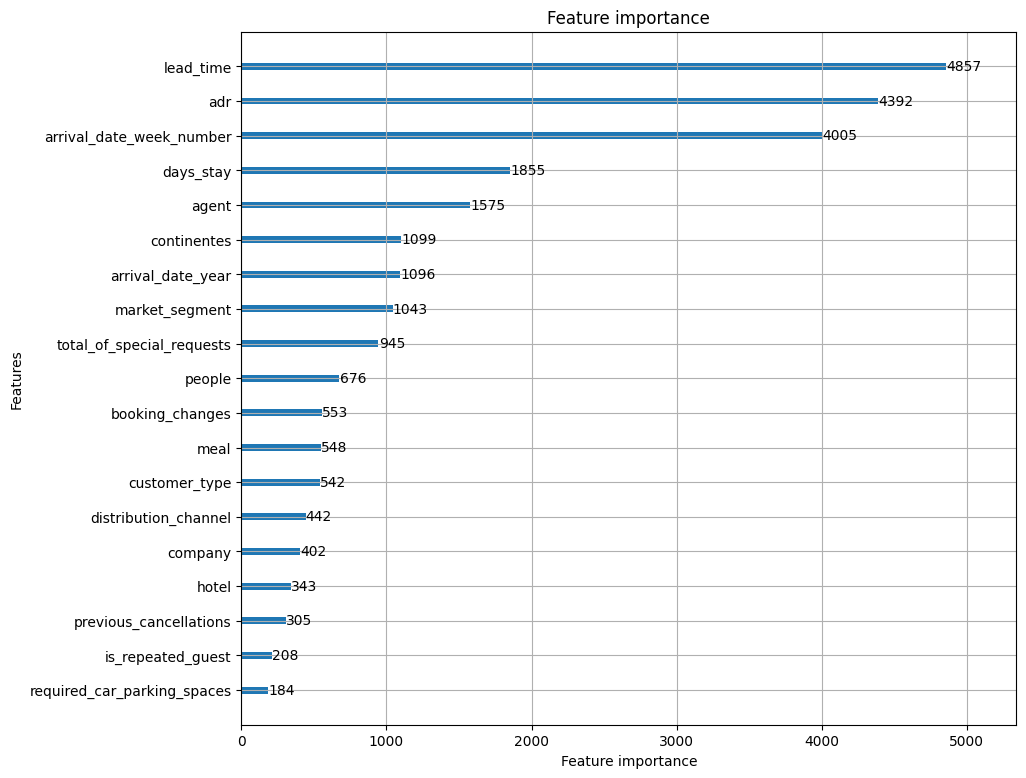

In [386]:
lgbm = LGBMClassifier(**lgbm_best_params)#**lgbm_best_params
lgbm.fit(X, y)
lightgbm.plot_importance(lgbm, figsize=(10, 9));

In [387]:
# fi_lgbm = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': lgbm.feature_importances_
# }).sort_values('importance', ascending=False)

# plt.figure(figsize=(10,6))
# plt.title('Feature Importance - LGBM Classifier')
# sns.barplot(data=fi_lgbm.head(20), x='importance', y='feature', color='SteelBlue');

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">XGBoost Feature Importance</p></div>

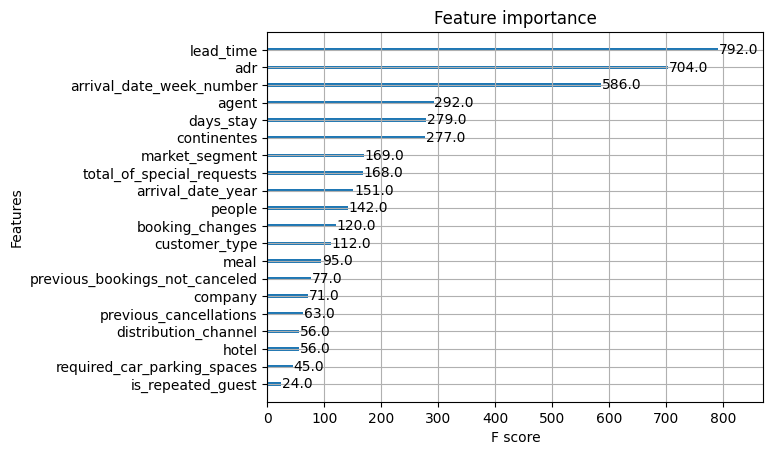

In [111]:
xgb = XGBClassifier()#**xgb_best_params
xgb.fit(X,y)
xgboost.plot_importance(xgb);

#fig1=plt.gcf()
#plt.draw()

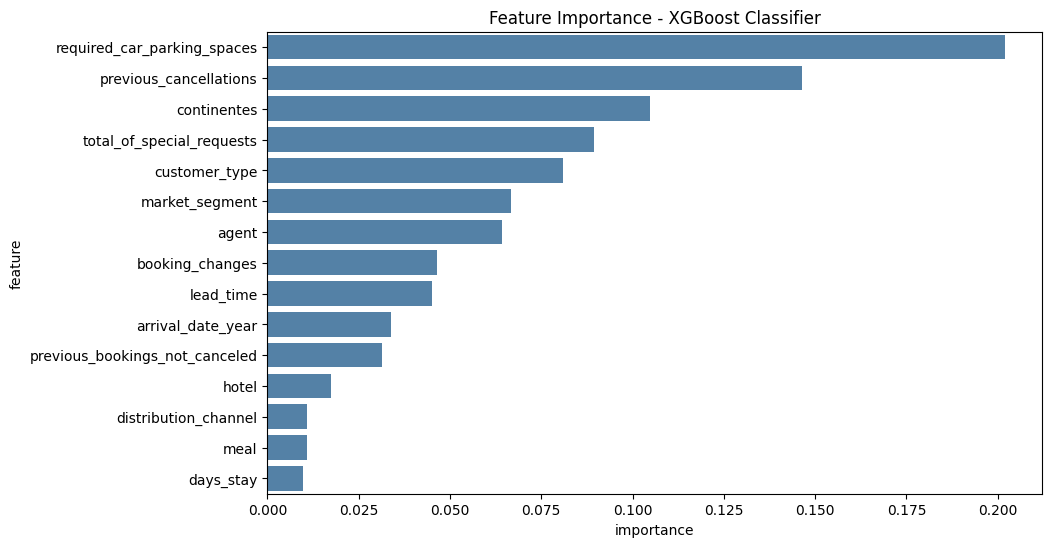

In [112]:
fi_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
plt.title('Feature Importance - XGBoost Classifier')
sns.barplot(data=fi_xgb.head(15), x='importance', y='feature', color='SteelBlue');
plt.show()

In [147]:
# lightgbm.plot_tree(lgbm, figsize=(12,12), tree_index=0, dpi=300)

## <div style="color:white;display:fill;border-radius:5px;background-color:#153656;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Filter Methods</p></div>

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Anova</p></div>

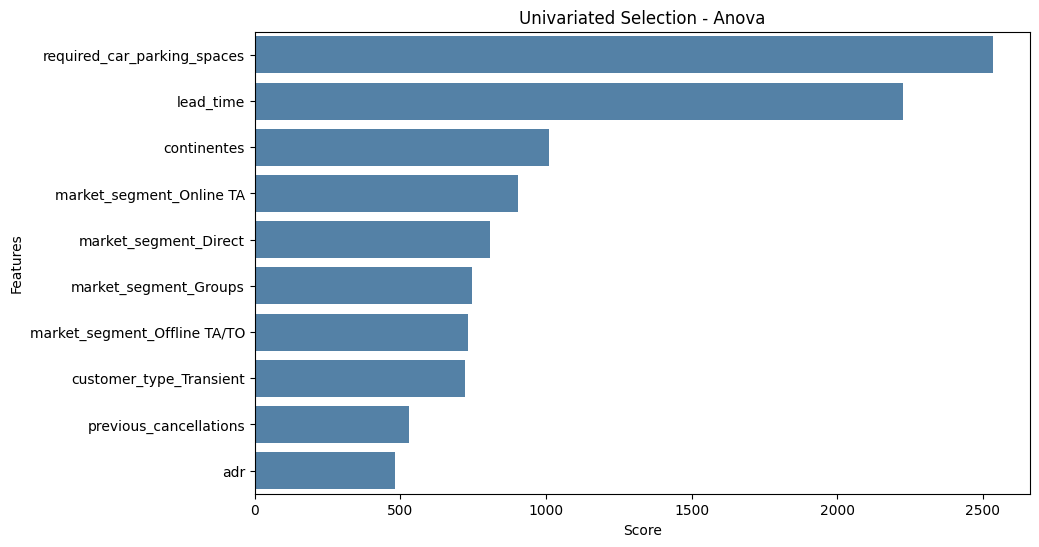

In [141]:
### Apply SelectKBest Algorithm - Anova
anova = SelectKBest(score_func=f_classif, k=10).fit(X,y)
anova_scores=pd.DataFrame(anova.scores_,columns=["Score"])
anova_columns=pd.DataFrame(X.columns)
anova_feature_rank=pd.concat([anova_columns,anova_scores],axis=1)
anova_feature_rank.columns=['Features','Score']
anova_feature_rank=anova_feature_rank.nlargest(10,'Score')

plt.figure(figsize=(10,6))
plt.title('Univariated Selection - Anova')
sns.barplot(data=anova_feature_rank, x='Score', y='Features', color='SteelBlue');
plt.show()

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Correlation Coeficient</p></div>

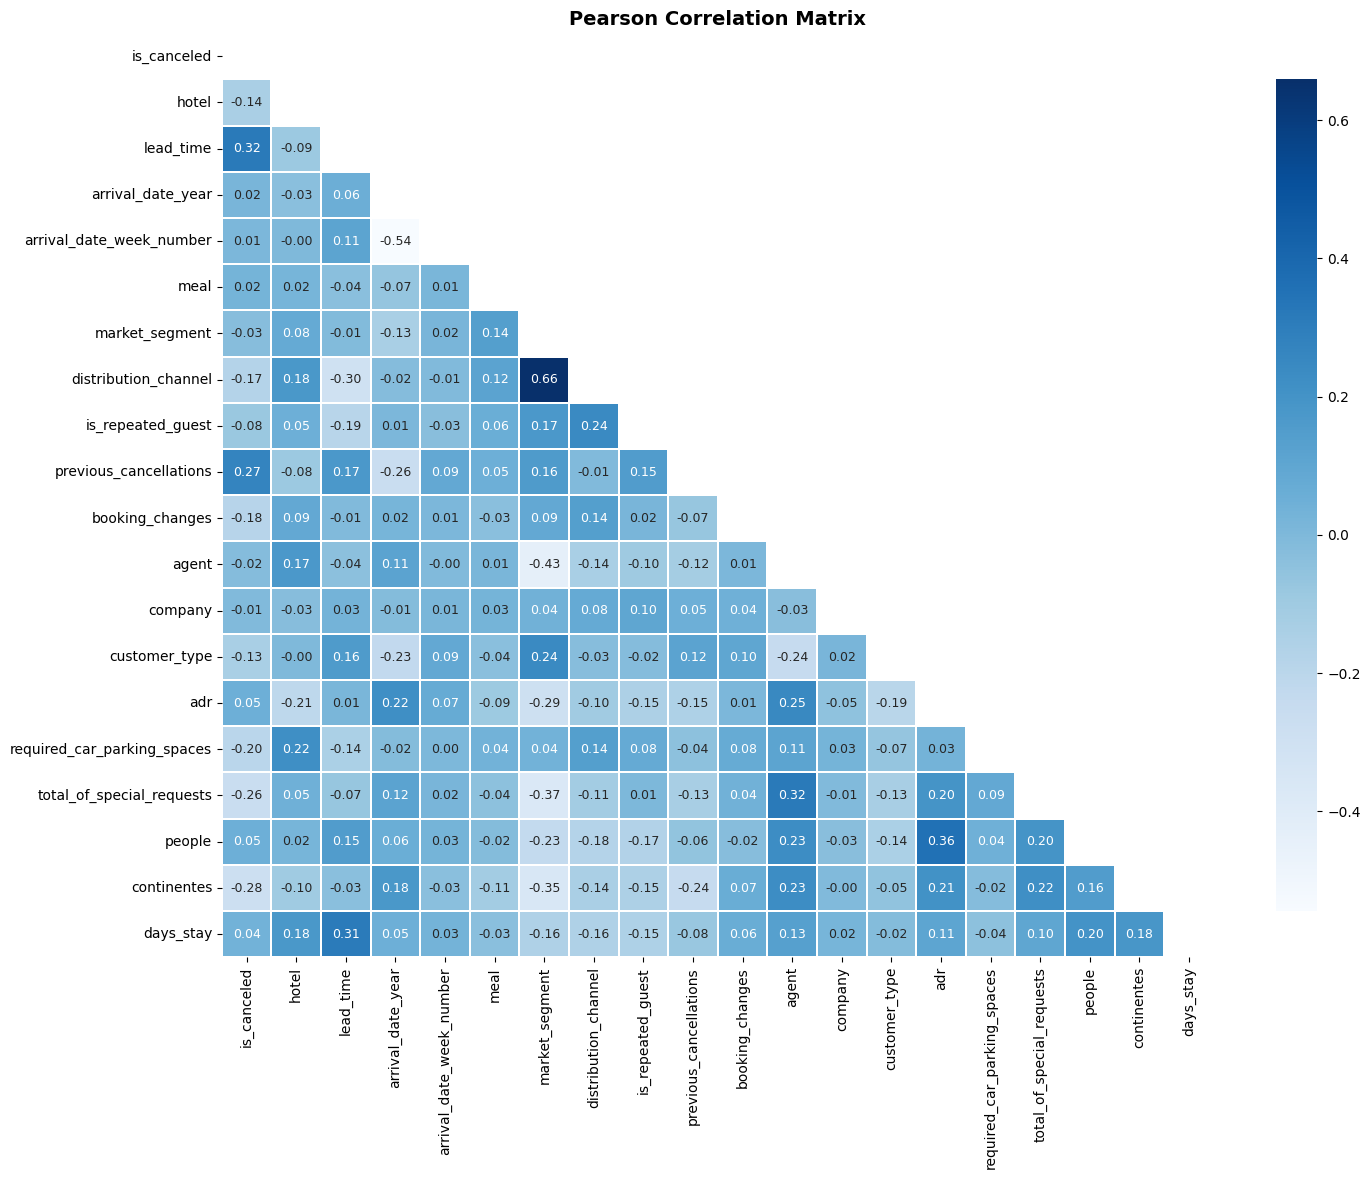

In [388]:
aux = pd.concat([data_prep[target],data_prep[selected_features]], axis=1)

mask = np.zeros_like(aux.corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))

plt.title('Pearson Correlation Matrix',fontsize=14, fontweight='bold')

sns.heatmap(aux.corr(method='spearman'), linewidths=0.25,fmt=".2f", cmap="Blues", linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Shapley</p></div>

In [53]:
shap.initjs()

In [54]:
model = LGBMClassifier(**lgbm_best_params)#**lgbm_best_params
model.fit(X, y)


explainer = shap.Explainer(model, X)
shap_values = explainer(X)

[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15


100%|===================| 119089/119234 [12:55<00:00]        

In [453]:
# train = pd.concat([X,y], axis=1)
# train.loc[train.is_canceled ==1].tail()

In [76]:
#300 Not Canceled, Resort Hotel, Parking Required - Acertou
#96 Canceled, Native, Special Request - Acertou

#138,630 Canceled,
#630 Canceled
#120 Not Canceled, Resort Hotel, Native
#151 Not Canceled, Resort Hotel, No Native

#96655 Not Canceled, City Hotel, No Native
#95241 Not Canceled City Hotel, No Native
idx = 96655

In [77]:
#data.groupby('customer_type')['is_canceled'].mean()

In [78]:
#data.groupby(['arrival_date_year','hotel'])['is_canceled'].mean()

In [79]:
data.iloc[idx,:]

hotel                                City Hotel
is_canceled                                   0
lead_time                                    94
arrival_date_year                          2016
arrival_date_month                    September
arrival_date_week_number                     36
arrival_date_day_of_month                     3
stays_in_weekend_nights                       2
stays_in_week_nights                          2
adults                                        2
children                                      1
babies                                        0
meal                                         BB
country                                     ITA
market_segment                    Offline TA/TO
distribution_channel                      TA/TO
is_repeated_guest                             0
previous_cancellations                        0
previous_bookings_not_canceled                0
reserved_room_type                            A
assigned_room_type                      

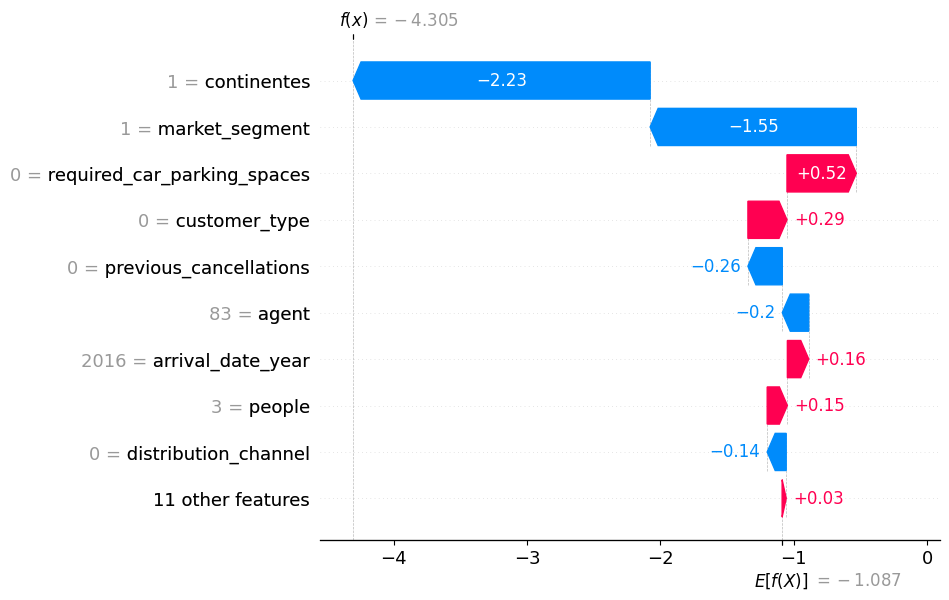

In [80]:
shap.plots.waterfall(shap_values[idx,:])

In [75]:
# visualize the first prediction's explanation with a force plot
#shap.plots.force(shap_values[idx,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


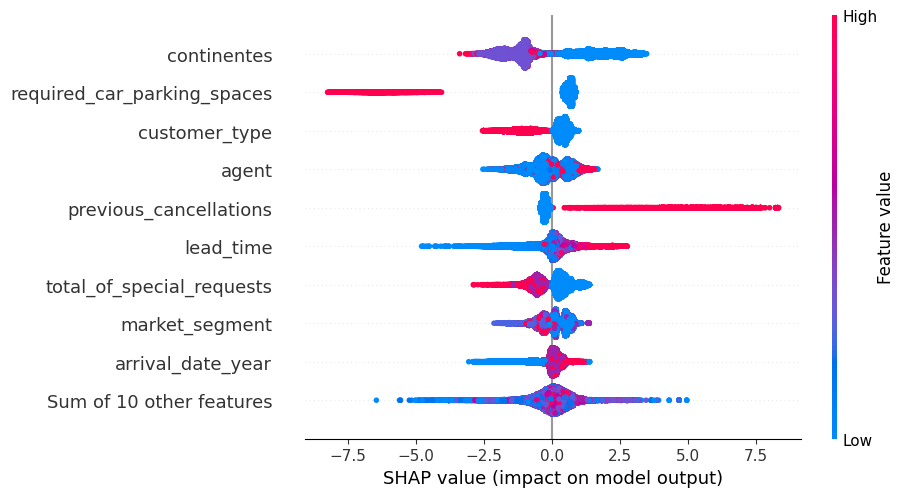

In [396]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

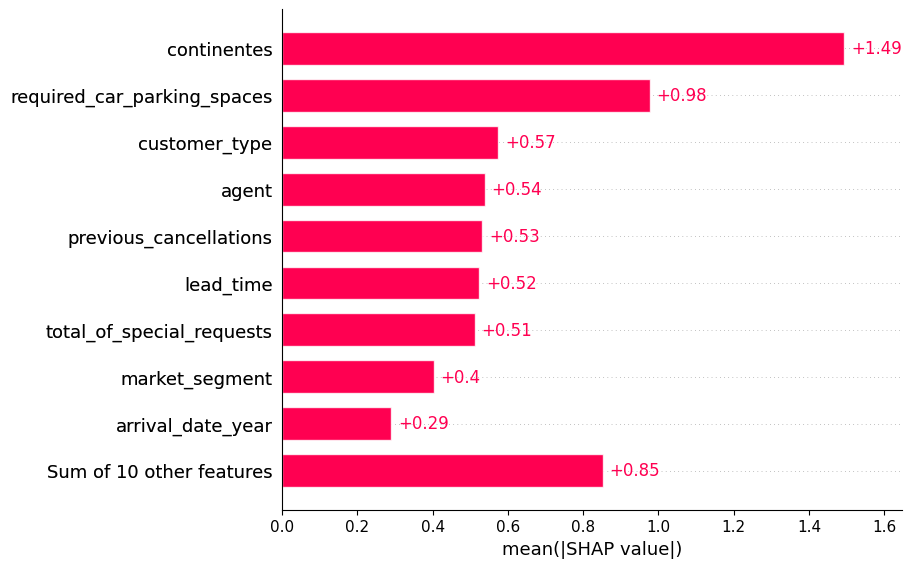

In [429]:
shap.plots.bar(shap_values)

In [81]:
shap.plots.force(shap_values[0:100])

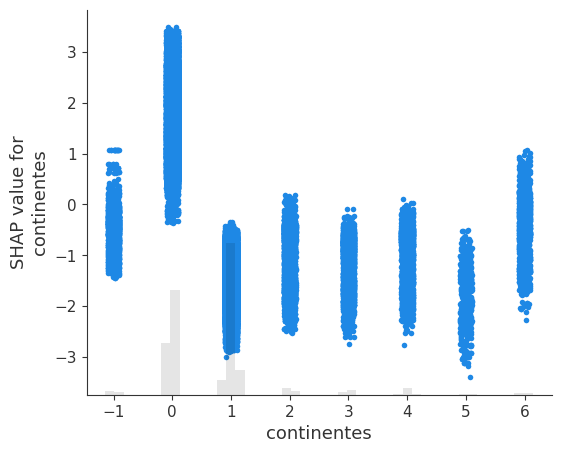

In [436]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"continentes"])#, color=shap_values

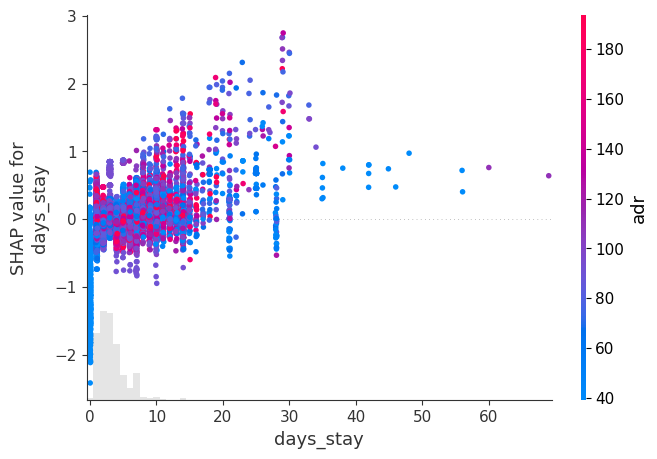

In [452]:
shap.plots.scatter(shap_values[:,"days_stay"],
                   color=shap_values[:,"adr"])

In [448]:
data.customer_type.unique(), data.customer_type.value_counts()

(array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object),
 Transient          89496
 Transient-Party    25091
 Contract            4072
 Group                575
 Name: customer_type, dtype: int64)

In [450]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'people', 'kids',
       'days_stay', 'country_name', 'continentes'],
      dtype='object')